In [51]:
from lsst.daf.persistence import Butler
import matplotlib.pyplot as plt
import lsst.afw
import numpy as np
import lsst.eotest.image_utils as imutils
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import time

from lsst.eotest.sensor.AmplifierGeometry import makeAmplifierGeometry
import lsst.ip.isr as isr
import sys

In [4]:
import lsst.afw.display     as afwDisplay 
afwDisplay.setDefaultBackend('matplotlib') 

In [5]:
def bias_isr(raw, overscan_correct=True):
    raw_clone = raw.clone()
    
    task = isr.isrTask.IsrTask()
    task.config.doAssembleCcd = True
    task.assembleCcd.config.doTrim = True
    #task.config.overscanFitType = 'MEDIAN_PER_ROW'
    task.config.doOverscan = overscan_correct
    task.config.doBias = False
    task.config.doLinearize = False
    task.config.doDark = False
    task.config.doFlat = False
    task.config.doDefect = False
    
    assembled = task.run(raw_clone).exposure
    return assembled.getImage()
    #del raw_clone

In [37]:
sensors = butler.queryMetadata('raw', ['raftName', 'detectorName'], dataId={'run': runnum})

In [40]:
sensors[0][1]

'SG0'

In [6]:
repo_directory = "/lsstdata/offline/teststand/BOT/gen2repo"
butler = Butler(repo_directory)

In [7]:
runnum = '6790D'
visits = butler.queryMetadata('raw', ['visit', 'imageType'], dataId={'run': runnum})#6790D
flats = butler.queryMetadata('raw', ['visit'], dataId={'run': runnum, 'imageType' : 'FLAT'})

In [8]:
flats1 = flats[::2]
flats2 = flats[1::2]

In [9]:
trios = []
for i in range(len(visits)-2):
    if visits[i][1] == 'FLAT' and visits[i+1][1] == 'FLAT' and visits[i+2][1] == 'BIAS':
        trios += [[visits[i][0], visits[i+1][0], visits[i+2][0]]]

In [29]:
sensors = butler.queryMetadata('raw', ['raftName', 'detectorName'], dataId={'run': runnum, 'visit':3019101200233})

In [32]:
sensors = butler.queryMetadata('raw', ['raftName', 'detectorName'], dataId={'run': runnum, 'visit':3019101200233})
raft, ccd = sensors[0]

<Figure size 432x288 with 0 Axes>

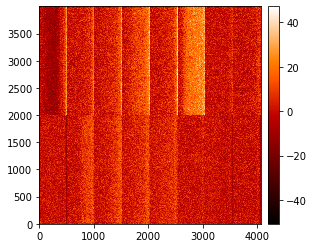

(4000, 4072)


In [44]:
plot_interleaved_bias(1, trios, sensors[10][0],sensors[10][1],overscan_correct=True)

In [36]:
def plot_interleaved_bias(num, trios, raft_name, detector_name, overscan_correct=False, compute_std=False, title=None, saveas=None, **figoptions):
    bias_visit = trios[num][2]
    dId_bias = {'visit': bias_visit, 'raftName': raft_name,'detectorName': detector_name}
    bias_exp = butler.get('raw', dId_bias)
    if overscan_correct:
        bias_im = bias_isr(bias_exp)
    else:
        bias_im = bias_exp.getImage()
    bias_arr = bias_im.getArray()
    fig = plt.figure(**figoptions)                            #create a matplotlib.pyplot figure
    afw_display = afwDisplay.Display()      #get an alias to the lsst.afw.display.Display() method
    afw_display.scale('linear', 'zscale')    #set the image stretch algorithm and range
    afw_display.setImageColormap('gist_heat')
    afw_display.mtv(bias_im, title)           #load the image into the display
    fig.patch.set_facecolor('white')
    if saveas is not None:
        plt.savefig(saveas)
    plt.show()                              #show the corresponding pyplot figure
    
    print(bias_arr.shape)
    
    if compute_std:
        stdev = np.std(bias_im.getArray())
        del bias_exp
        return stdev
    else:
        del bias_exp

In [11]:
raft_name ='R10'
detector_name ='S10'
bias_visit = visits[0][0]
dId_bias = {'visit': bias_visit, 'raftName': raft_name,'detectorName': detector_name}
detector_serial = butler.get('raw', dId_bias).getInfo().getDetector().getSerial()

In [52]:
def dataname(butler, runnum, raft_name, detector_name):
    bias_visit = visits[0][0]
    dId_bias = {'visit': bias_visit, 'raftName': raft_name,'detectorName': detector_name}
    detector_serial = butler.get('raw', dId_bias).getInfo().getDetector().getSerial()
    return 'Run {}: {} - {}: {}'.format(runnum, raft_name, detector_name, detector_serial)

In [ ]:
def calculate_flux_memory(butler, trios, runnum, raft_name, detector_name, n_flux_selection=500, plot_biases=False, do_isr=True):
    bias_info_by_flux = pd.DataFrame(columns=('flux', 'bias_mean', 'bias_std'))
    start_time = time.time()
    time_remaining = ''
    for i in range(len(trios)):
        if i != 0:
            time_remaining = '{:.2f}'.format((time.time()-start_time)*(len(trios)-i)/i/60)
        print('Set {}/{}: ------ Minutes left: {}'.format(i,len(trios), time_remaining), end="\r")
        flat_visit_1 = trios[i][0]
        #flat_visit_2 = trios[i][1]
        bias_visit   = trios[i][2]
        dId_flat1 = {'visit': flat_visit_1, 'raftName': raft_name,'detectorName': detector_name}
        flat_1_exp = butler.get('raw', dId_flat1)
        flat_1_exp_corrected = bias_isr(flat_1_exp)
        flux = np.mean(np.random.choice(np.ravel(flat_1_exp_corrected.getArray()), n_flux_selection, replace=False))
        dId_bias = {'visit': bias_visit, 'raftName': raft_name,'detectorName': detector_name}
        bias_exp = butler.get('raw', dId_bias)
        if do_isr:
            bias_im = bias_isr(bias_exp)
        else:
            bias_im = bias_exp.getImage()
        bias_arr = bias_im.getArray()
        if plot_biases:
            plt.figure()                            #create a matplotlib.pyplot figure
            afw_display = afwDisplay.Display()      #get an alias to the lsst.afw.display.Display() method
            afw_display.scale('asinh', 'zscale')    #set the image stretch algorithm and range
            afw_display.mtv(bias_im)           #load the image into the display
            plt.show()                              #show the corresponding pyplot figure
        bias_selection = bias_arr#np.random.choice(np.ravel(bias_arr),n_flux_selection, replace=False)
        bias_info_by_flux.loc[i] = [flux, np.mean(bias_selection), np.std(bias_selection)]
        del bias_exp, flat_1_exp, flat_1_exp_corrected
    bias_info_by_flux.to_pickle('{}/flux_memory_data/Run {}: {} - {}'.format(runnum, runnum, raft_name, detector_name))
    return bias_info_by_flux

In [81]:
print('{:.2f}'.format(0.432340293))

0.43


In [55]:
#bias_info_by_flux.to_pickle('{}/flux_memory_data/Run {}: {} - {}'.format(runnum, runnum, raft_name, detector_name))

In [48]:
#bias_info_by_flux = pd.read_pickle('{}/flux_memory_data/Run {}: {} - {}'.format(runnum, runnum, raft_name, detector_name))

In [159]:
bias_info_by_flux=bias_info_by_flux.sort_index()

In [13]:
def plot_noise_and_bias(bias_info_by_flux, runnum=runnum, raft_name=raft_name, detector_name=detector_name):
    fig = plt.figure();
    axes = bias_info_by_flux.plot(y=['bias_std','bias_mean'],stacked=True,secondary_y=['bias_std'], logy=True,figsize=(15,8))
    axes.set_xlabel('(Interleaved) Bias acquisition number')
    axes.set_ylabel('Mean of Bias Image (ADU)')
    plt.title('Run {}: {} - {}'.format(runnum, raft_name, detector_name))
    fig.patch.set_facecolor('white')

In [72]:
def plot_by_flux(bias_info_by_flux, butler, runnum, raft_name, detector_name):
    fig = plt.figure();
    fig.patch.set_facecolor('white')
    bias_info_by_flux_sorted = bias_info_by_flux.sort_values('flux')
    axes = bias_info_by_flux_sorted.plot(x='flux', y=['bias_std','bias_mean'],stacked=True,secondary_y=['bias_std'], logy=True, logx=False,figsize=(15,8))
    axes.set_xlabel('Flux of previous flat (ADU)')
    axes.set_ylabel('Mean of Bias Image (ADU)')
    axes.yaxis.set_label_coords(-.05,.5)
    
    rightaxis = axes.twinx()
    #rightaxis.tick_params(axis='y',which='both',right=False)
    rightaxis.tick_params(axis=u'both', which=u'both',right=u'off',length=0)
    rightaxis.set_yticklabels([])
    rightaxis.set_ylabel('Stdev of Bias Image (ADU)')
    rightaxis.yaxis.set_label_coords(1.05,.5)
    plt.title(dataname(butler, runnum, raft_name, detector_name))
    #plt.tight_layout()
    plt.savefig('{}/{}_{}_{}_by_flux'.format(runnum, runnum, raft_name, detector_name))
    #bias_info_by_flux.plot(x='flux', y=,stacked=True,secondary_y=True)
    #bias_info_by_flux.plot(x='flux', y=)

In [71]:
axes

In [71]:
def plot_flats_sequence(bias_info_by_flux, butler, runnum, raft_name, detector_name):
    fig, axes = plt.subplots(3,1)
    fig.patch.set_facecolor('white')
    fig.suptitle('Overscan corrected Interleaved Biases in {}'.format(dataname(butler, runnum, raft_name, detector_name)))
    bias_info_by_flux.plot(y='bias_std', logy=True,figsize=(15,8), ax=axes[0])
    axes[0].set_ylabel('Std (ADU)')
    
    bias_info_by_flux.plot(y='bias_mean', logy=True,figsize=(15,8), ax=axes[1])
    axes[1].set_ylabel('Mean (ADU)')
    
    bias_info_by_flux.plot(y='flux', logy=False,figsize=(15,8), ax=axes[2])
    axes[2].set_ylabel('Flux of previous flat (ADU)')
    axes[2].set_xlabel('Bias acquisition number');
    #plt.tight_layout()
    plt.savefig('{}/{}_{}_{}_biases'.format(runnum, runnum, raft_name, detector_name))

In [69]:
def run_flux_memory_ccd(runnum, raft_name, detector_name):
    bias_info_by_flux = calculate_flux_memory(butler, trios, runnum, raft_name, detector_name, n_flux_selection=500, plot_biases=False, do_isr=True)
    plot_by_flux(bias_info_by_flux, butler, runnum, raft_name, detector_name)
    plot_flats_sequence(bias_info_by_flux, butler, runnum, raft_name, detector_name)

In [78]:
def run_flux_memory_all_ccds(runnum):
    #rafts = ['R10', 'R22', 'R01', 'R02', 'R11', 'R12', 'R20', 'R21', 'R30']
    #slots = ['S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22']
    sensors = butler.queryMetadata('raw', ['raftName', 'detectorName'], dataId={'run': runnum, 'visit':3019101200233})
    start_time = time.time()
    for i, (raft, slot) in enumerate(sensors):
        if slot not in ['S00', 'S01', 'S02', 'S10', 'S11', 'S12', 'S20', 'S21', 'S22']:
            continue
        print('Running {} - {}'.format(raft,slot))
        run_flux_memory_ccd(runnum, raft, slot)
        print('***Done***')
        print('Elapsed time: {:.2f} min ----- Estimated remaining: {:.2f} min'.format((time.time()-start_time)/60, (time.time()-start_time)*(len(sensors)-i-1)/(i+1)/60))

In [ ]:
run_flux_memory_all_ccds('6790D')

Running R01 - S00
***Done***4: ------ Minutes left: 0.106
Elapsed time: 20.74 min ----- Estimated remaining: 369.24 min
Running R01 - S01
***Done***4: ------ Minutes left: 0.127
Elapsed time: 45.81 min ----- Estimated remaining: 671.82 min
Running R01 - S02
***Done***4: ------ Minutes left: 0.120
Elapsed time: 70.60 min ----- Estimated remaining: 877.44 min
Running R01 - S10


<Figure size 720x720 with 0 Axes>

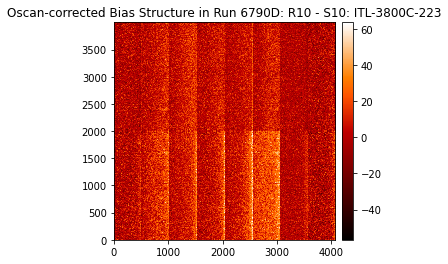

(4000, 4072)


11.312569

In [58]:
plot_interleaved_bias(-4,compute_std=True, overscan_correct=True, title='Oscan-corrected Bias Structure in {}'.format(dataname(butler, runnum, raft_name, detector_name)), saveas='6790D/bias_structure_108_{}_{}_{}'.format(runnum, raft_name, detector_name), figsize=(10,10))

<Figure size 720x720 with 0 Axes>

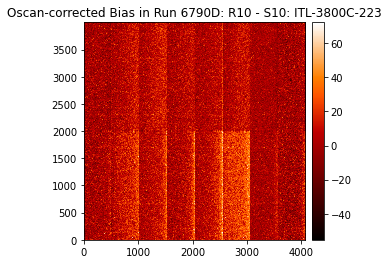

(4000, 4072)


11.522521

In [51]:
plot_interleaved_bias(150,compute_std=True, overscan_correct=True, title='Oscan-corrected Bias in {}'.format(dataname(butler, runnum, raft_name, detector_name)), saveas='6790D/bias_structure_113_6790D_{}_{}'.format(raft_name, detector_name), figsize=(10,10))

In [91]:
np.sqrt(bias_info_by_flux['bias_std'][136])

14.03592454566026

<Figure size 720x720 with 0 Axes>

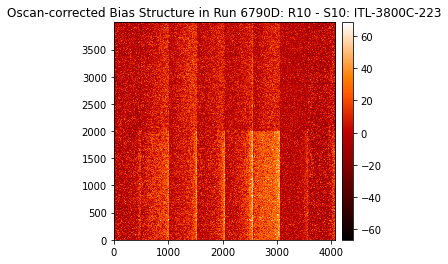

(4000, 4072)


11.601409

In [53]:
plot_interleaved_bias(94,compute_std=True, overscan_correct=True, title='Oscan-corrected Bias Structure in {}'.format(dataname(butler, runnum, raft_name, detector_name)), saveas='6790D/bias_structure_94_6790D_{}_{}'.format(raft_name, detector_name), figsize=(10,10))

In [58]:
bias_info_by_flux_sorted = bias_info_by_flux.sort_values('flux')

0        284.623605
1        569.888180
2      31719.591949
3      11957.236889
4        281.121127
           ...     
209    38570.304271
210    63166.086019
211    76462.012778
212     8392.673447
213     1759.945187
Name: flux, Length: 214, dtype: float64

In [71]:
bias_info_by_flux['bias_std'] 

0      196.954647
1      197.002726
2      197.032318
3      196.421144
4      196.897459
          ...    
209    197.289326
210    197.272753
211    196.941437
212    197.097642
213    196.290989
Name: bias_std, Length: 214, dtype: float64

In [29]:
bias_visit = visits[0][0]
dId_bias = {'visit': bias_visit, 'raftName': raft_name,'detectorName': detector_name}
bias_exp = butler.get('raw', dId_bias).getInfo().getDetector().getPhysicalType()

In [26]:
dir(butler)

['GENERATION',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_addParents',
 '_assignDefaultMapper',
 '_connectParentRepoDatas',
 '_convertV1Args',
 '_getBypassFunc',
 '_getCfgs',
 '_getDefaultMapper',
 '_getOldButlerRepositoryCfg',
 '_getParentRepoData',
 '_getParentVal',
 '_getParents',
 '_getRepositoryCfg',
 '_initArgs',
 '_initRepo',
 '_locate',
 '_processInputArguments',
 '_read',
 '_repos',
 '_resolveDatasetTypeAlias',
 '_setAndVerifyParentsLists',
 '_setDefaultMapper',
 '_setRepoDataTags',
 'dataRef',
 'datasetExists',
 'datasetTypeAliasDict',
 'defineAlias',
 'get',
 'getDatasetTypes',
 'getKeys',
 'getMapperClass',
 'getUri',
 'log',
 'put',
 'queryMetadata'

In [13]:
dir(bias_exp);
info = bias_exp.getInfo()

In [14]:
dir(info);
dir(info.getDetector())
info.getDetector().getPhysicalType()

'ITL'